In [1]:
library(Seurat)
library(data.table)
library(stringr)
library(ggplot2)
library(dplyr)
library(reticulate)

Attaching SeuratObject

Attaching sp


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
fn = function(p, no.legend=T) {
    lx = unlist(lapply(p$patches$plots, function(x) {ggplot_build(x)$layout$panel_scales_x[[1]]$range$range}))
    ly = unlist(lapply(p$patches$plots, function(x) {ggplot_build(x)$layout$panel_scales_y[[1]]$range$range}))
    p = p & theme(panel.grid=element_line(colour="grey", size=0.5)) & xlim(min(lx), max(lx)) & ylim(min(ly), max(ly)) 
    if (no.legend) p = p & NoLegend()
    return(p)
}

In [3]:
path2root = "/work/magroup/tianming/Researches/sc-hic/data2/final"
print(path2root)

[1] "/work/magroup/tianming/Researches/sc-hic/data2/final"


# Load our data

In [53]:
data <- Read10X(data.dir = file.path(path2root, "results", "RNA_mBC_complete_mm10_filtered_10x"))
obj <- CreateSeuratObject(counts = data, project = "mBC", min.cells = 10)
df_meta = read.csv(
    file.path(path2root, "results", "meta_mBC_complete_mm10_filtered.csv"), header = TRUE,
    row.name = 1, sep = ",",
)
print(dim(df_meta))
stopifnot(all.equal(colnames(obj), rownames(df_meta)))
obj = AddMetaData(obj, df_meta)
obj[['dataset']] = 'CARE-seq'
obj[['dataset2']] = obj[['batch']]

path2file = file.path(path2root, "results", "meta-Seurat_mBC_complete_mm10_filtered.csv")
print(path2file)
df = read.csv(path2file, row.names=1)
obj = obj[,rownames(df)]
obj$seurat_clusters = df
Idents(obj) = obj$seurat_clusters
levels(obj) = c(
    "L2 IT RvPP", "L2/3 IT RSP", "L2/3 IT CTX a", "L2/3 IT CTX b", "L2/3 IT CTX c",
    "L4 IT CTX", "L4/5 IT CTX", "L5 IT RSP", "L5 IT CTX", "L6 IT CTX",
    "L5 PT CTX", "L6 CT CTX a", "L6 CT CTX b", "L5/6 NP CTX", "L6b CTX",
    "Pvalb a", "Pvalb b", "Sst a", "Sst b", "Vip", "Sncg", "Lamp5", "Meis2",
    "Astro", "OPC", "ODC", "VLMC", "Micro", "Unk")

obj.care = obj
obj

[1] 4454  187
[1] "/work/magroup/tianming/Researches/sc-hic/data2/final/results/meta-Seurat_mBC_complete_mm10_filtered.csv"


An object of class Seurat 
17019 features across 3296 samples within 1 assay 
Active assay: RNA (17019 features, 0 variable features)

In [55]:
obj.care <- NormalizeData(obj.care, verbose=F)
obj.care <- FindVariableFeatures(obj.care, verbose=F)
obj.care <- ScaleData(obj.care, features=rownames(obj.care), verbose=F)
obj.care <- RunPCA(obj.care, verbose=F, npcs = 40)

# Zhang 2021 BICCN

In [28]:
path2dir = '/work/magroup/tianming/Researches/scRNAseq_data/Zhang2021BICCN'
obj <- CreateSeuratObject(
    counts = t(read.csv(file.path(path2dir, 'counts.csv'), check.names=F, row.names=1)),
    projecct = "Zhang2021",
)
obj <- NormalizeData(obj)
obj = AddMetaData(obj, read.csv(file.path(path2dir, 'cell_labelsx.csv'), check.names = T, row.names = 1))
obj = AddMetaData(obj, metadata='Zhang2021', col.name='dataset')
obj$dataset2 = obj$sample_id
# obj = subset(obj, subset=sample_id%in%c('mouse1_sample1'))
# obj = subset(obj, subset=slice_id%in%c('mouse1_slice153'))
Idents(obj) = obj$label
obj.zhang2021 = obj
obj

An object of class Seurat 
254 features across 280186 samples within 1 assay 
Active assay: RNA (254 features, 0 variable features)

In [30]:
num_pcs = 20
obj <- obj.zhang2021
obj = subset(obj, downsample=50)
obj <- NormalizeData(obj, verbose=F)
# obj <- FindVariableFeatures(obj, verbose=F)
obj <- ScaleData(obj, verbose=F)
obj <- RunPCA(obj, features=rownames(obj), npcs = num_pcs, verbose=F)
obj <- RunUMAP(obj, min.dist=0, n.neighbors=20, dims = 1:num_pcs, verbose=F)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Warning message:
“ggrepel: 12 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



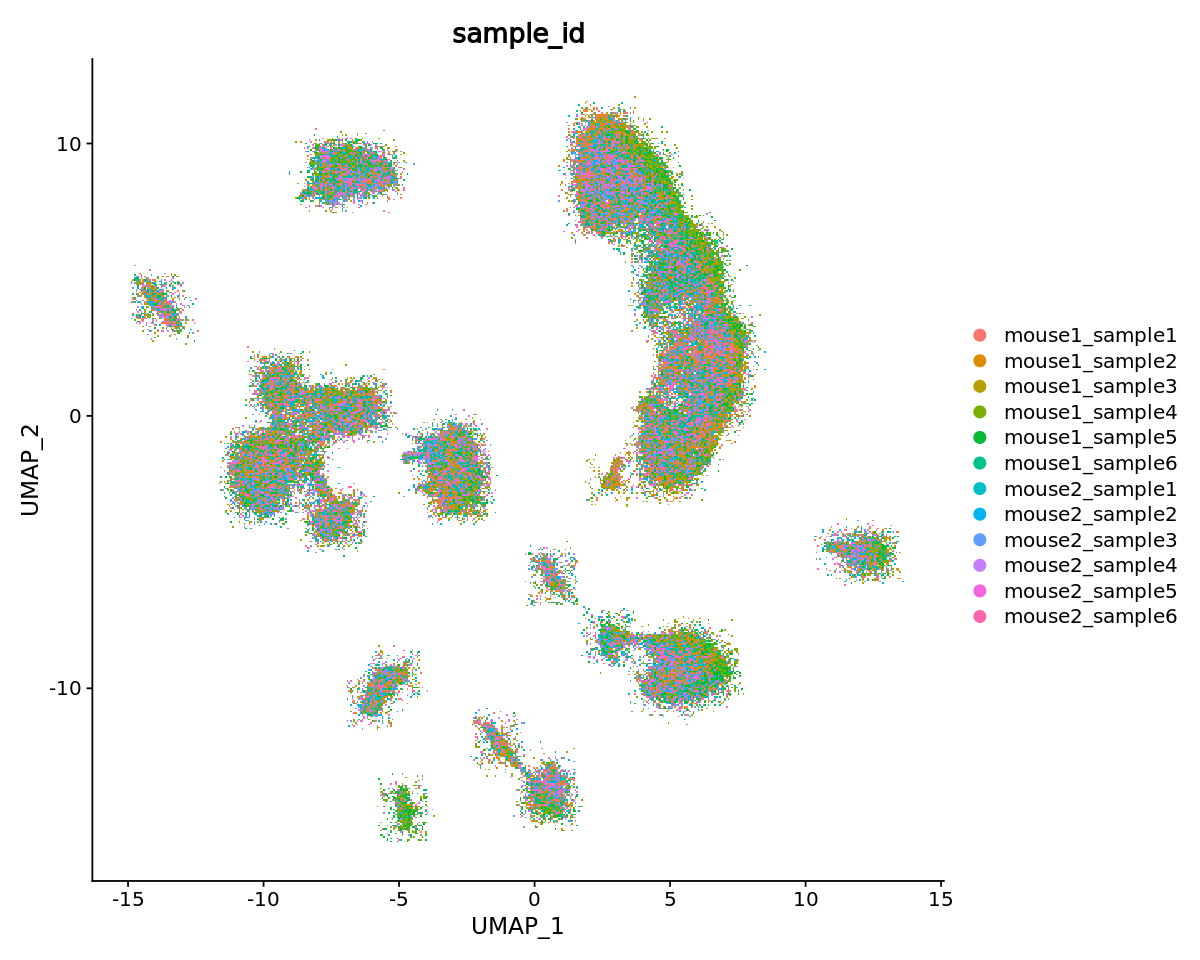

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



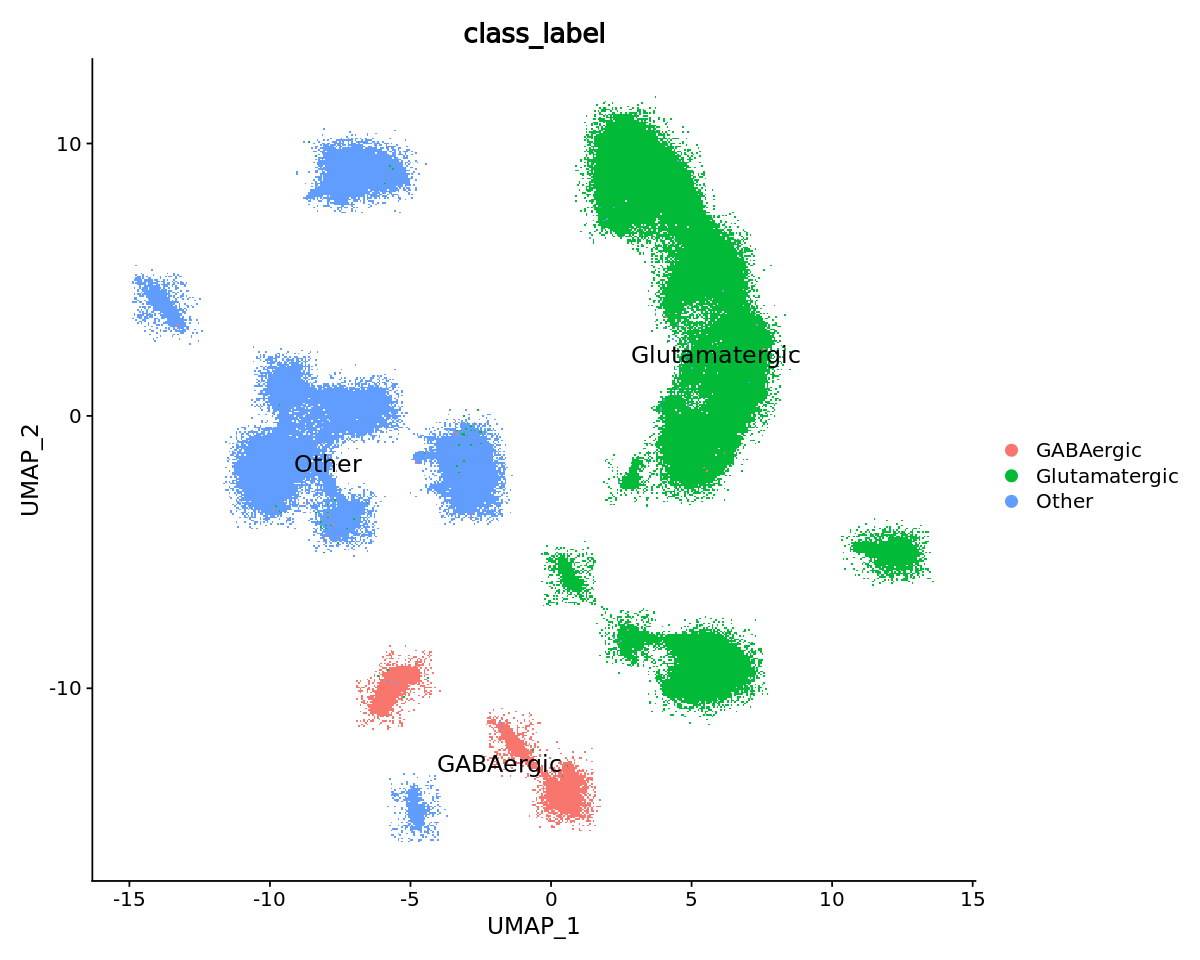

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



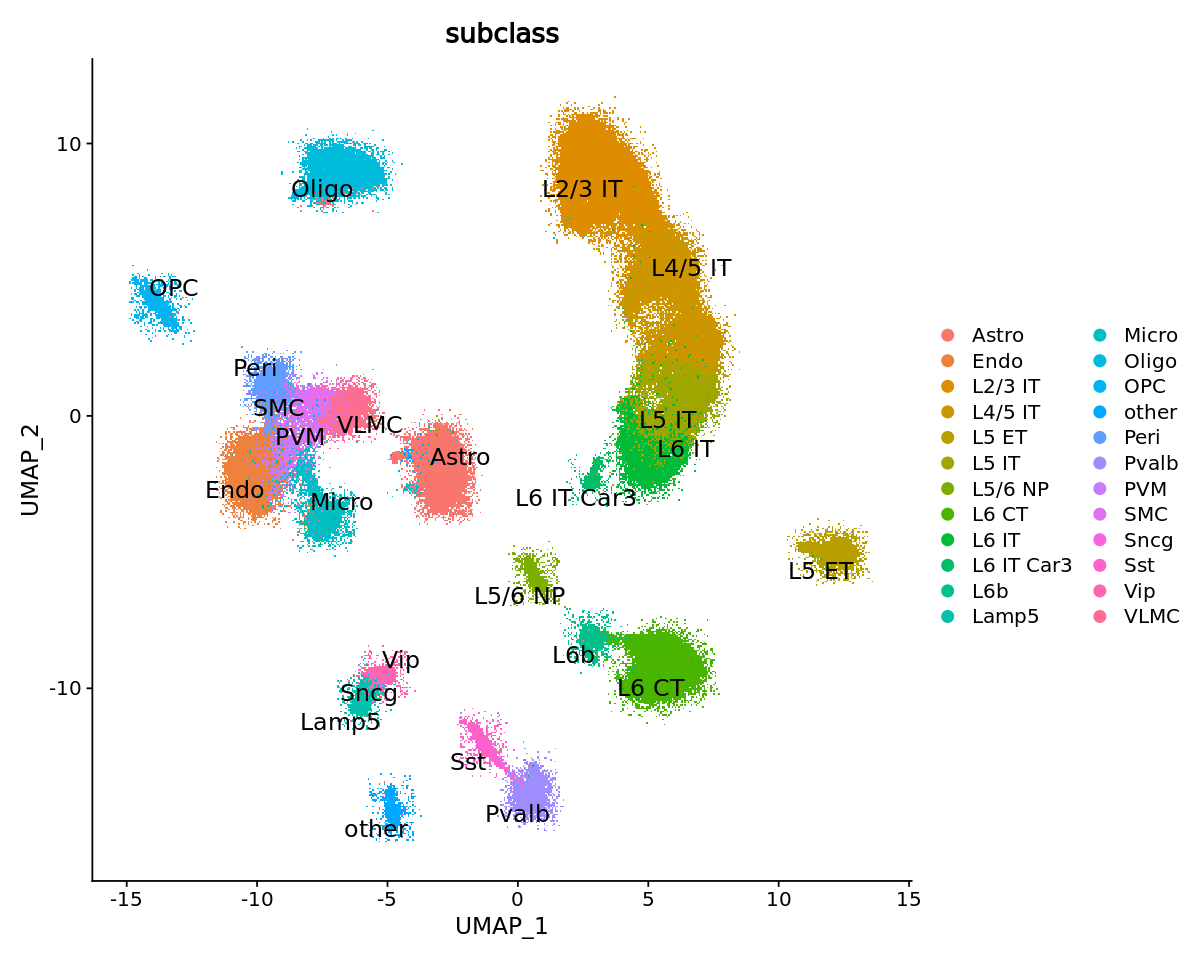

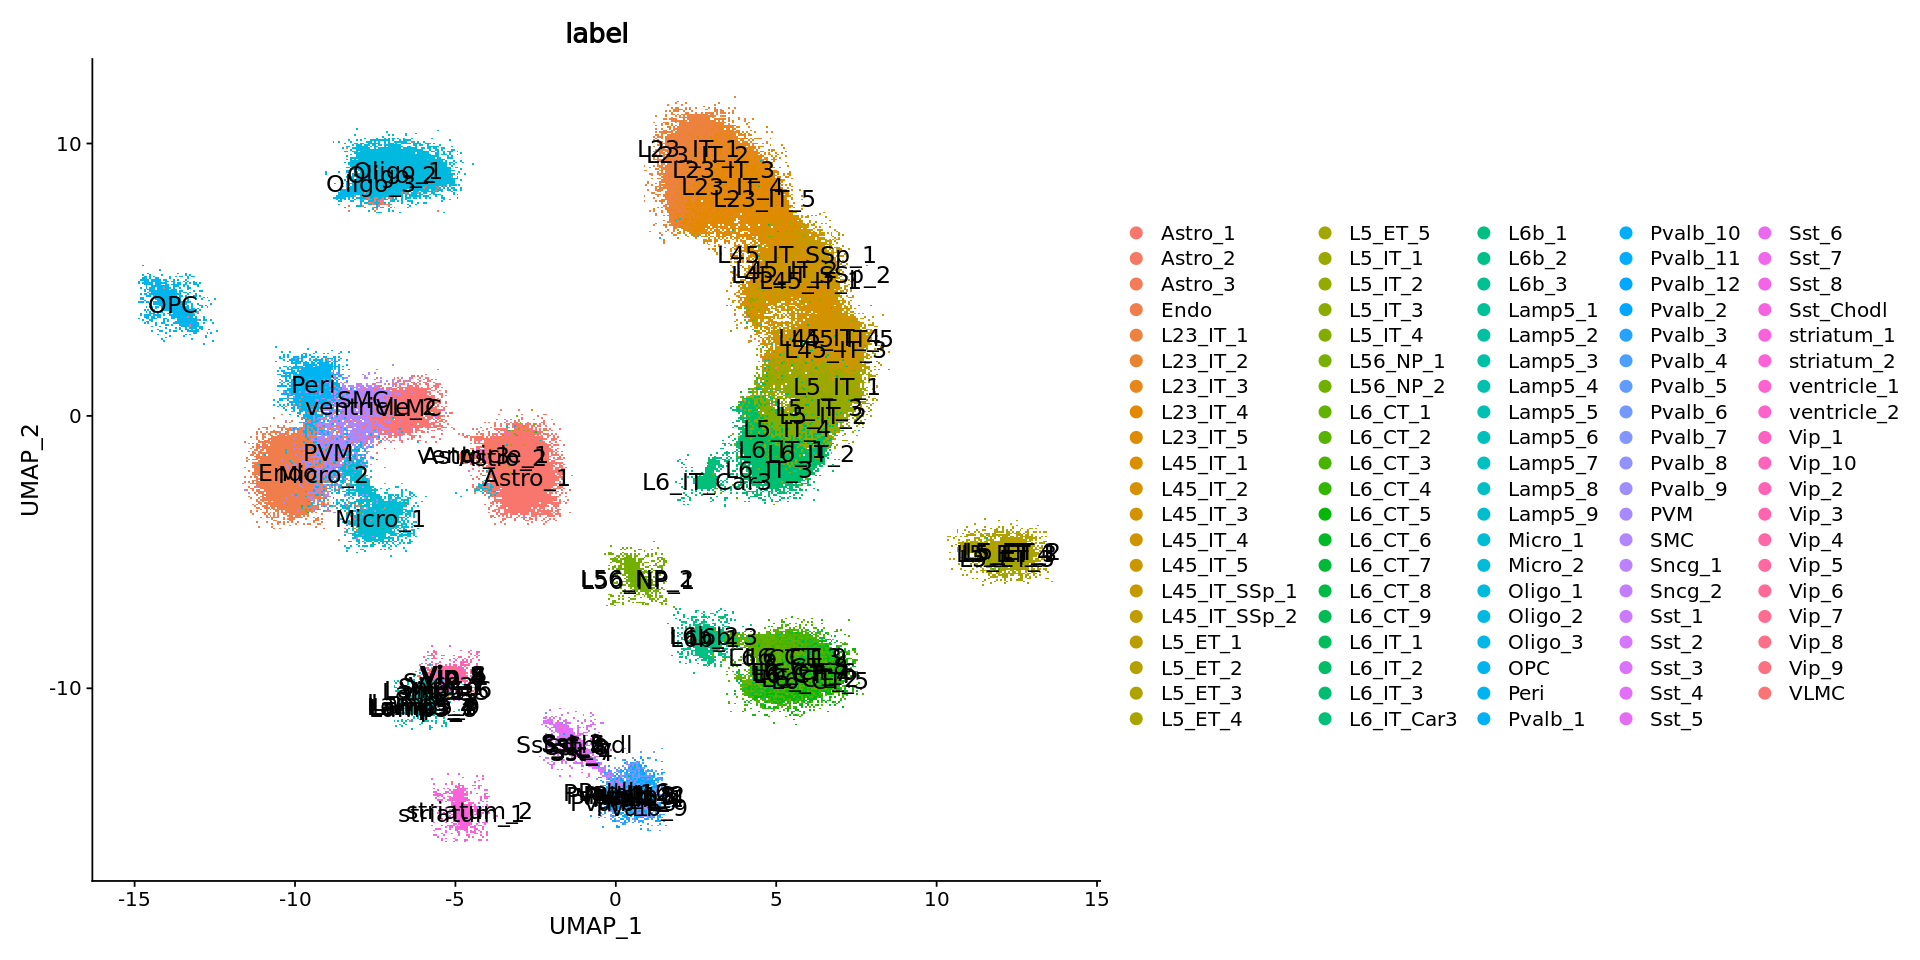

In [16]:
saved <- options(repr.plot.width=10, repr.plot.height=8)
DimPlot(obj, group.by='sample_id', label=T, repel=T, label.size=5)
DimPlot(obj, group.by='class_label', label=T, repel=T, label.size=5)
DimPlot(obj, group.by='subclass', label=T, repel=T, label.size=5)
options(saved)
saved <- options(repr.plot.width=16, repr.plot.height=8)
DimPlot(obj, group.by='label', label=T, repel=F, label.size=5)
options(saved)

## Zhang 2021 BICCN - Integration

In [56]:
path2root = "/work/magroup/tianming/Researches/sc-hic/data2/final"
path2figdir = file.path(path2root, 'figures-integrate-mBC-Zhang2021BICCN')
print(path2figdir)

[1] "/work/magroup/tianming/Researches/sc-hic/data2/final/figures-integrate-mBC-Zhang2021BICCN"


In [142]:
print(Sys.time())
obj.list <- list(
    subset(obj.zhang2021, subset=subclass%in%c(
        "L2/3 IT", "L4/5 IT", "L5 IT", "L5/6 NP", "L6 CT", "L6 IT", "L6b"
#         "Lamp5", "Pvalb", "Sncg", "Sst", "Vip"
    ) & slice_id=='mouse1_slice162'),
    subset(obj.care, subset=seurat_clusters%in%c(
        "L2/3 IT CTX a", "L2/3 IT CTX b", "L2/3 IT CTX c", "L4 IT CTX", "L4/5 IT CTX",
        "L5 IT CTX", "L6 IT CTX", "L6 CT CTX a", "L6 CT CTX b", "L5/6 NP CTX", "L6b CTX"
#         "Pvalb a", "Pvalb b", "Sst a", "Sst b", "Vip", "Sncg", "Lamp5", "Meis2"
    ))
)
print(Sys.time())
print(obj.list)
# features <- SelectIntegrationFeatures(object.list = obj.list, verbose=F)
features = intersect(rownames(obj.zhang2021), rownames(obj.care))
print(Sys.time())
anchors <- FindIntegrationAnchors(object.list = obj.list, anchor.features = features, verbose=F)
print(Sys.time())
obj.int.zhang2021 <- IntegrateData(anchorset = anchors, verbose=F)
print(Sys.time())

[1] "2023-03-17 16:11:49 EDT"
[1] "2023-03-17 16:11:52 EDT"
[[1]]
An object of class Seurat 
254 features across 3567 samples within 1 assay 
Active assay: RNA (254 features, 0 variable features)

[[2]]
An object of class Seurat 
17019 features across 1665 samples within 1 assay 
Active assay: RNA (17019 features, 2000 variable features)
 1 dimensional reduction calculated: pca

[1] "2023-03-17 16:11:52 EDT"
[1] "2023-03-17 16:12:16 EDT"
[1] "2023-03-17 16:12:22 EDT"


In [143]:
obj = obj.int.zhang2021
num_pcs = 10
obj <- ScaleData(obj, verbose=F)
obj <- RunPCA(obj, npcs = num_pcs, verbose=F)
obj <- RunUMAP(obj, min.dist=0, n.neighbors=20, dims = 1:num_pcs, verbose=F)
obj.int.zhang2021 = obj

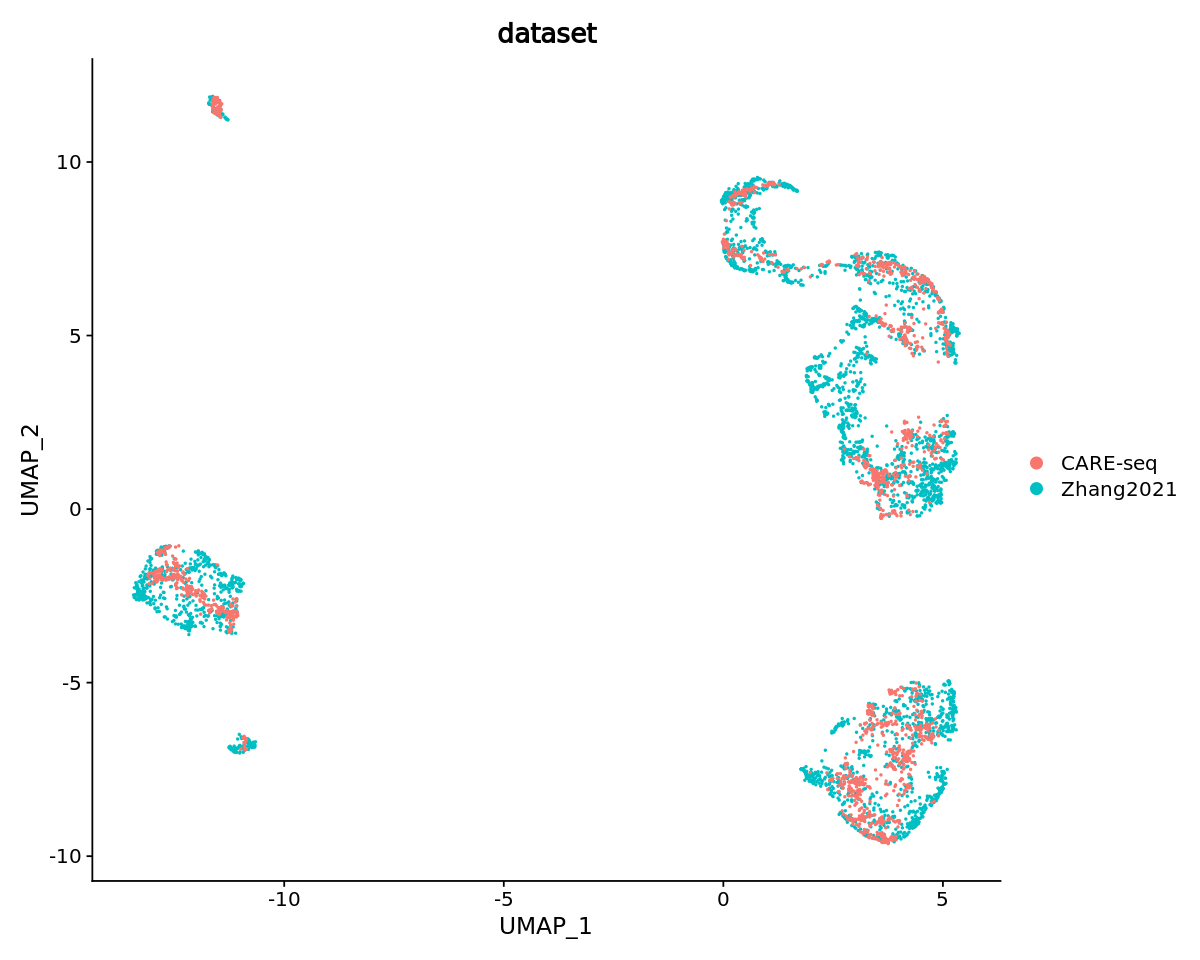

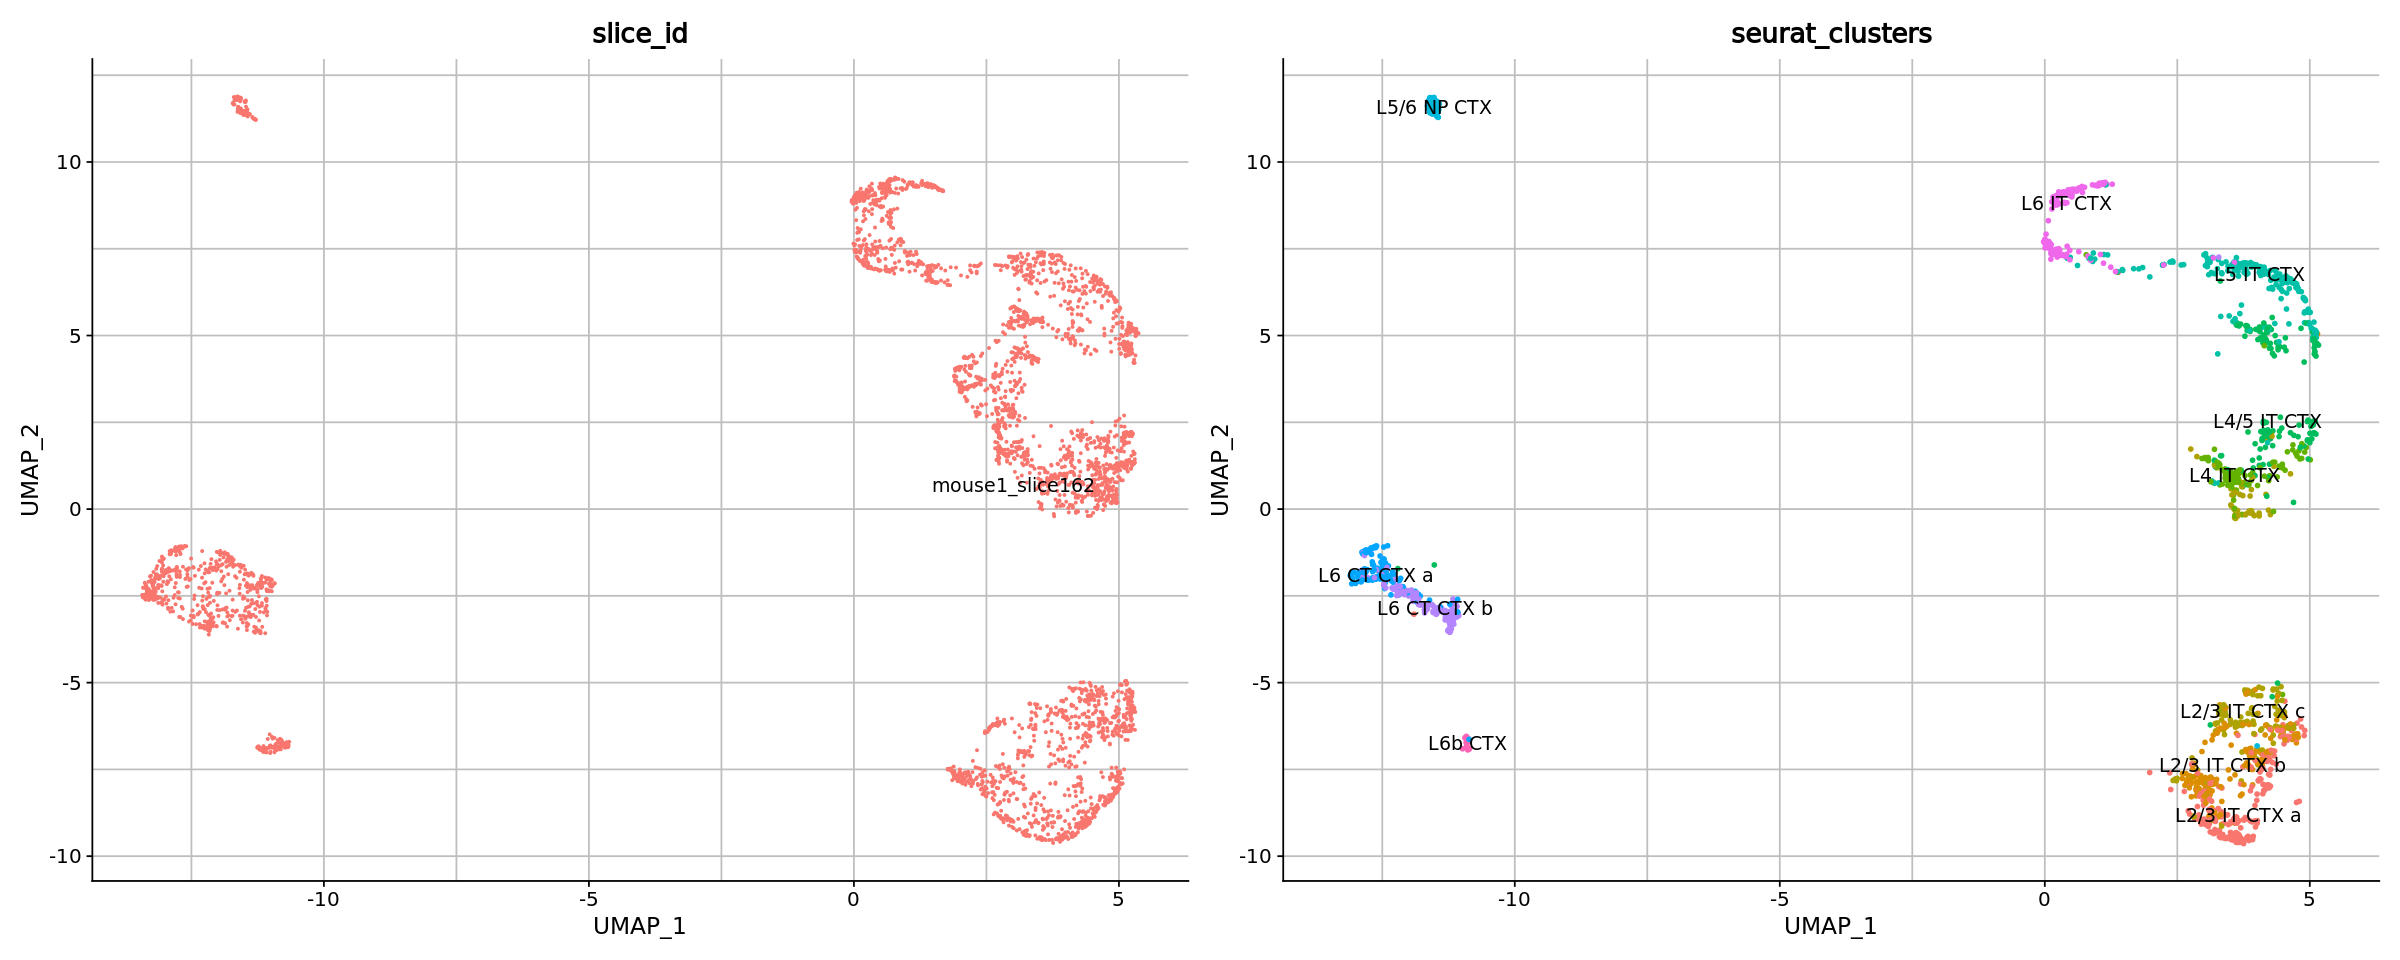

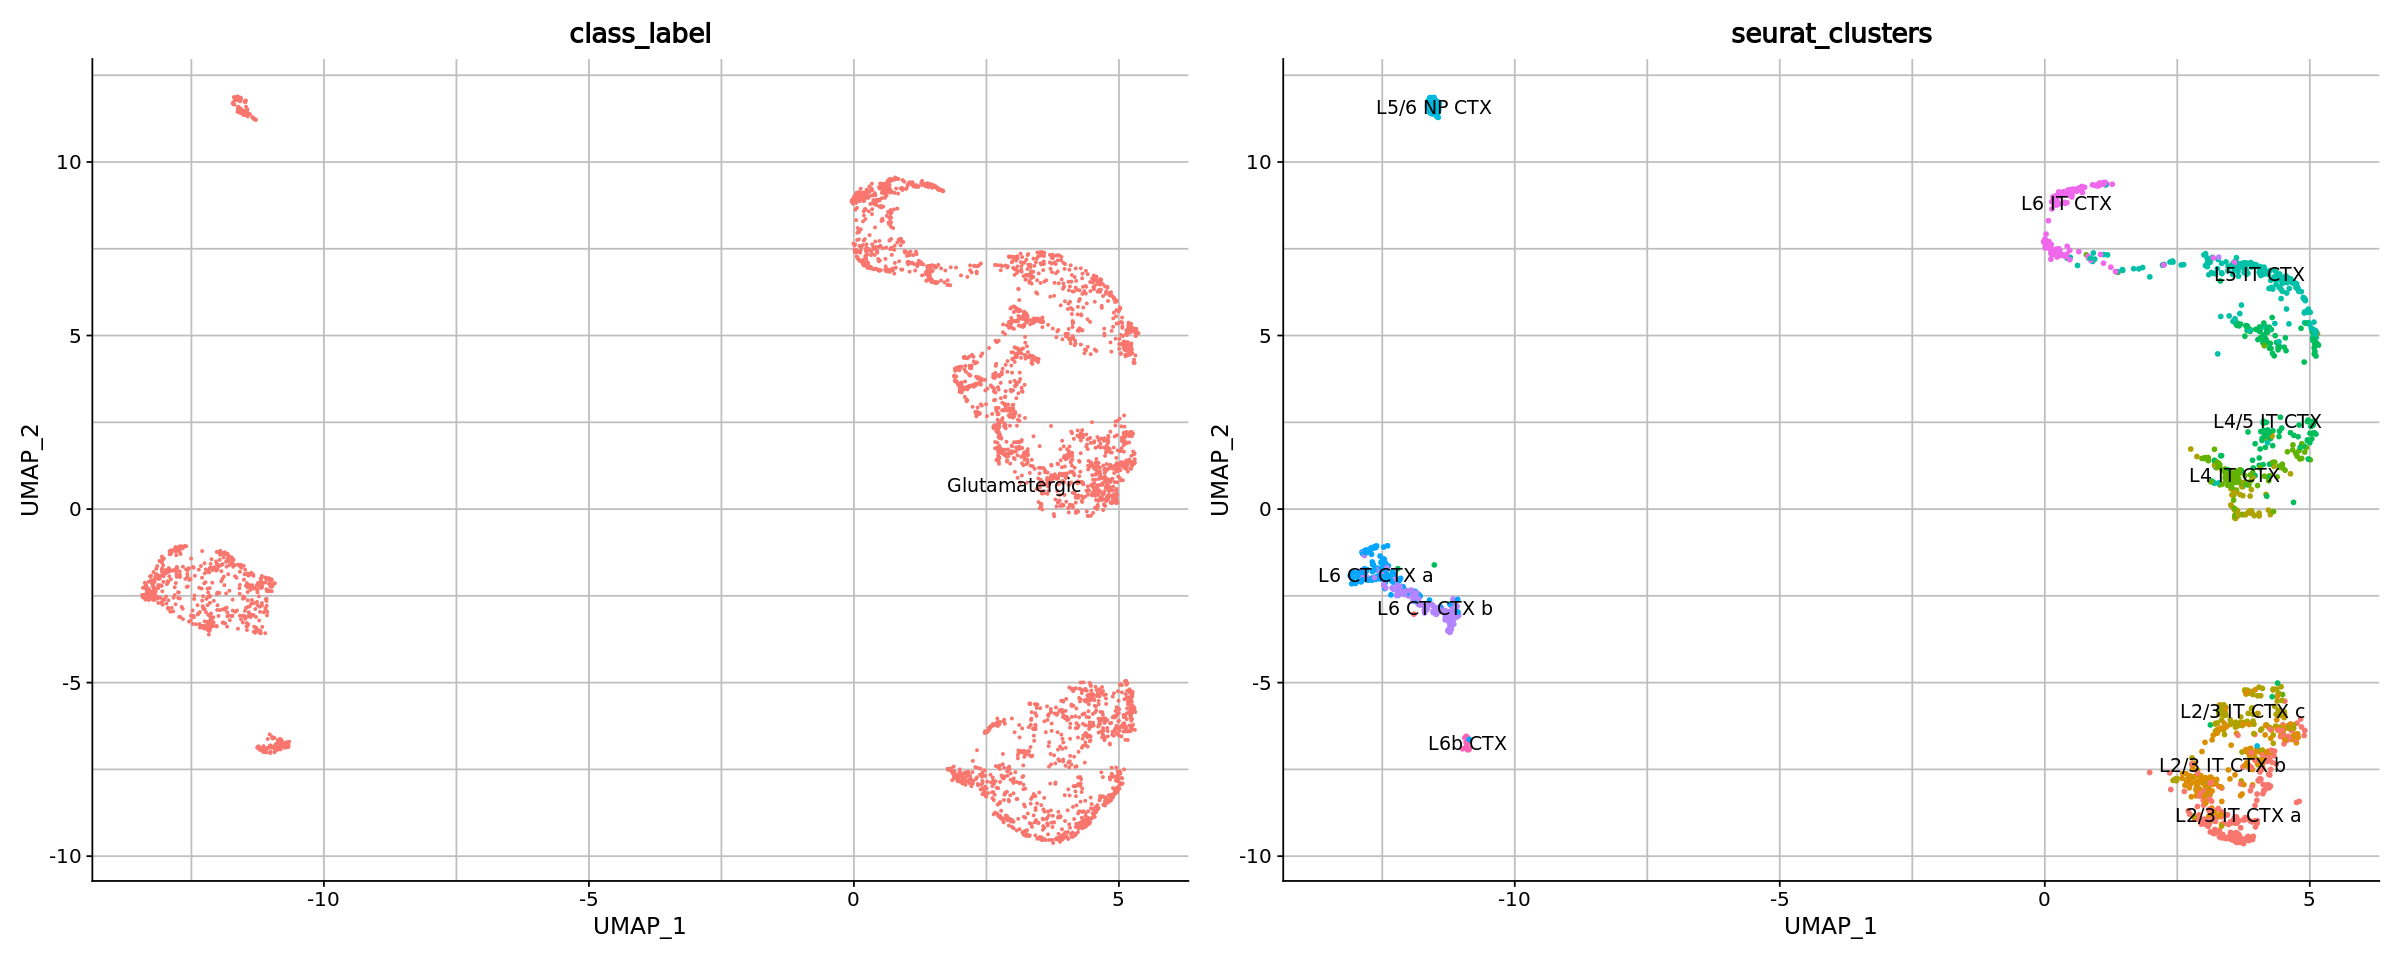

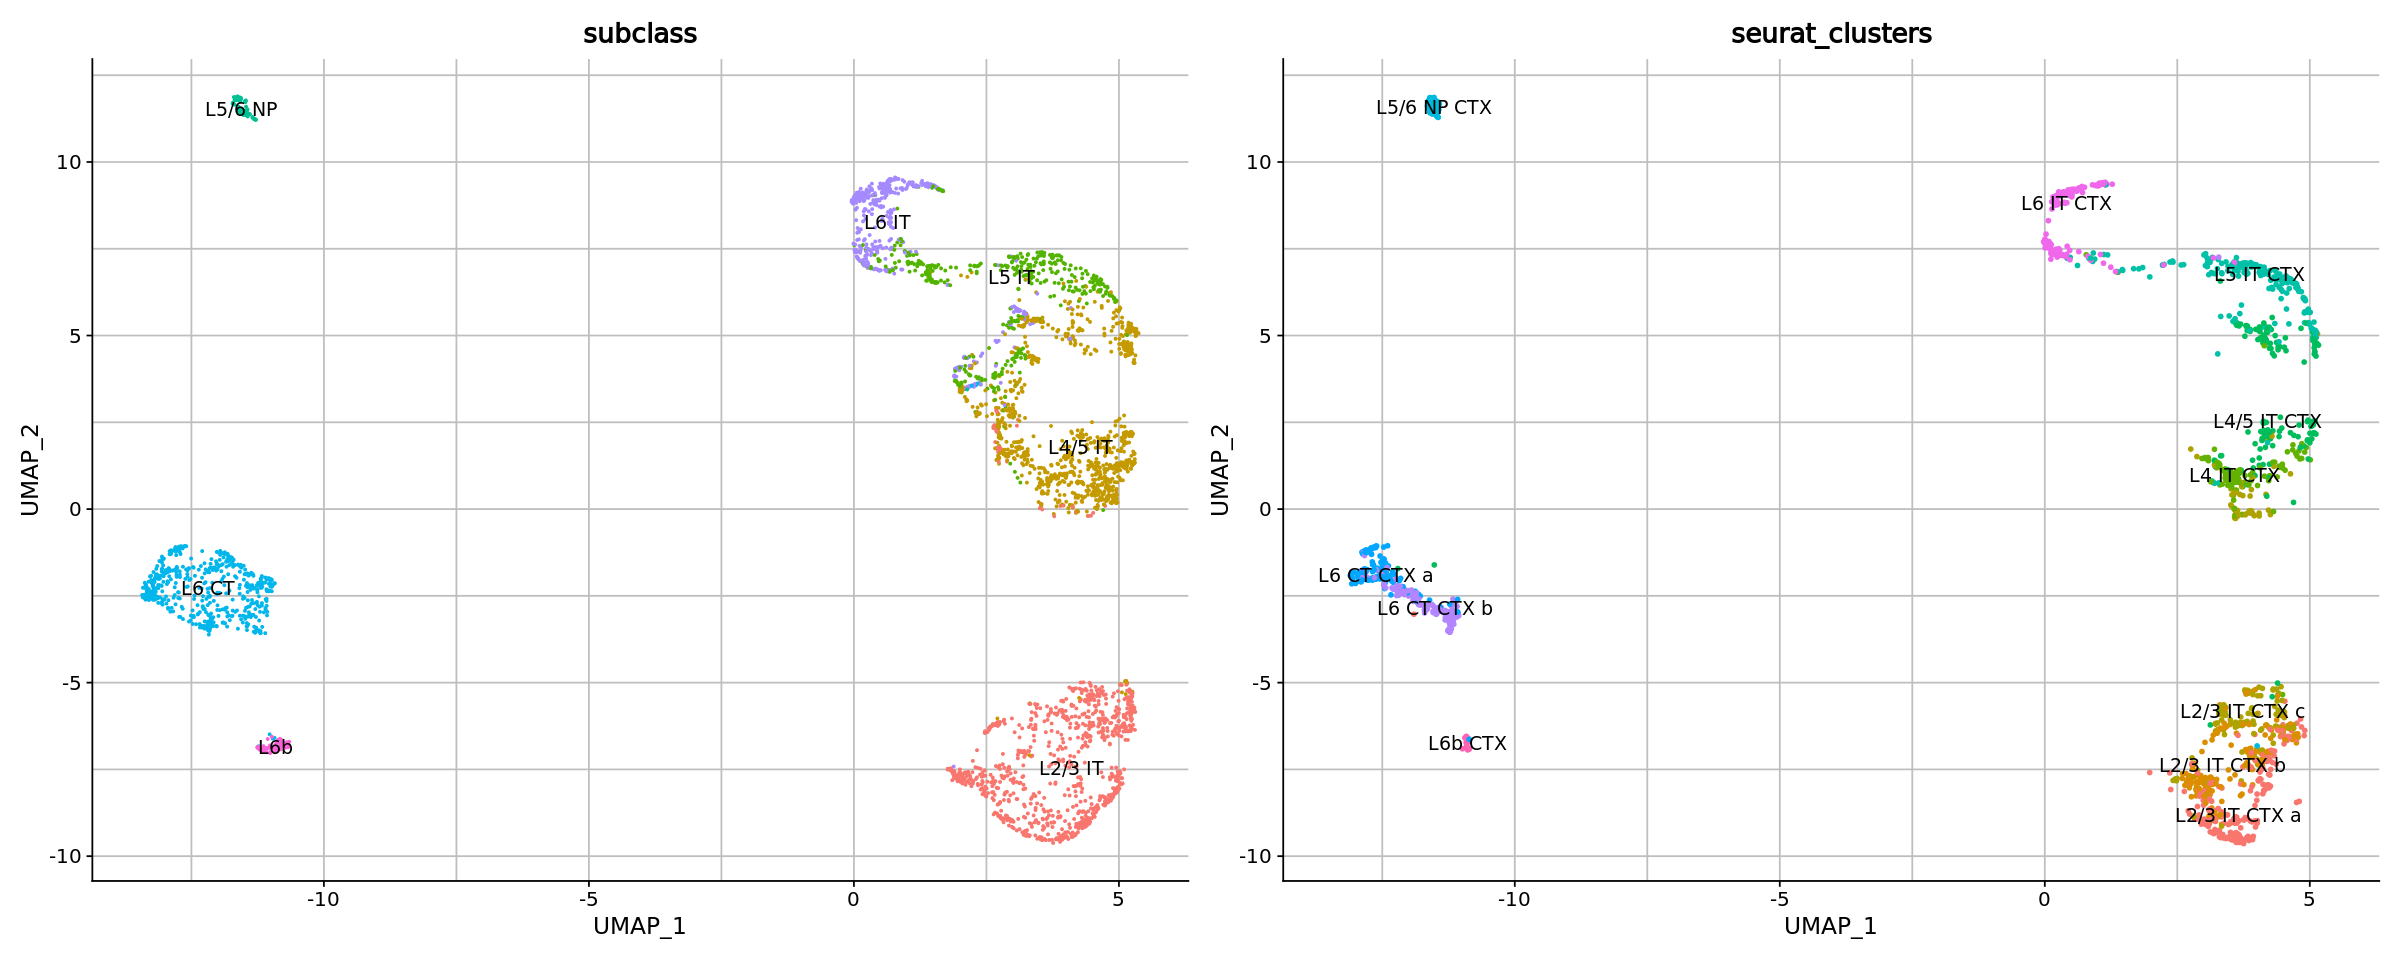

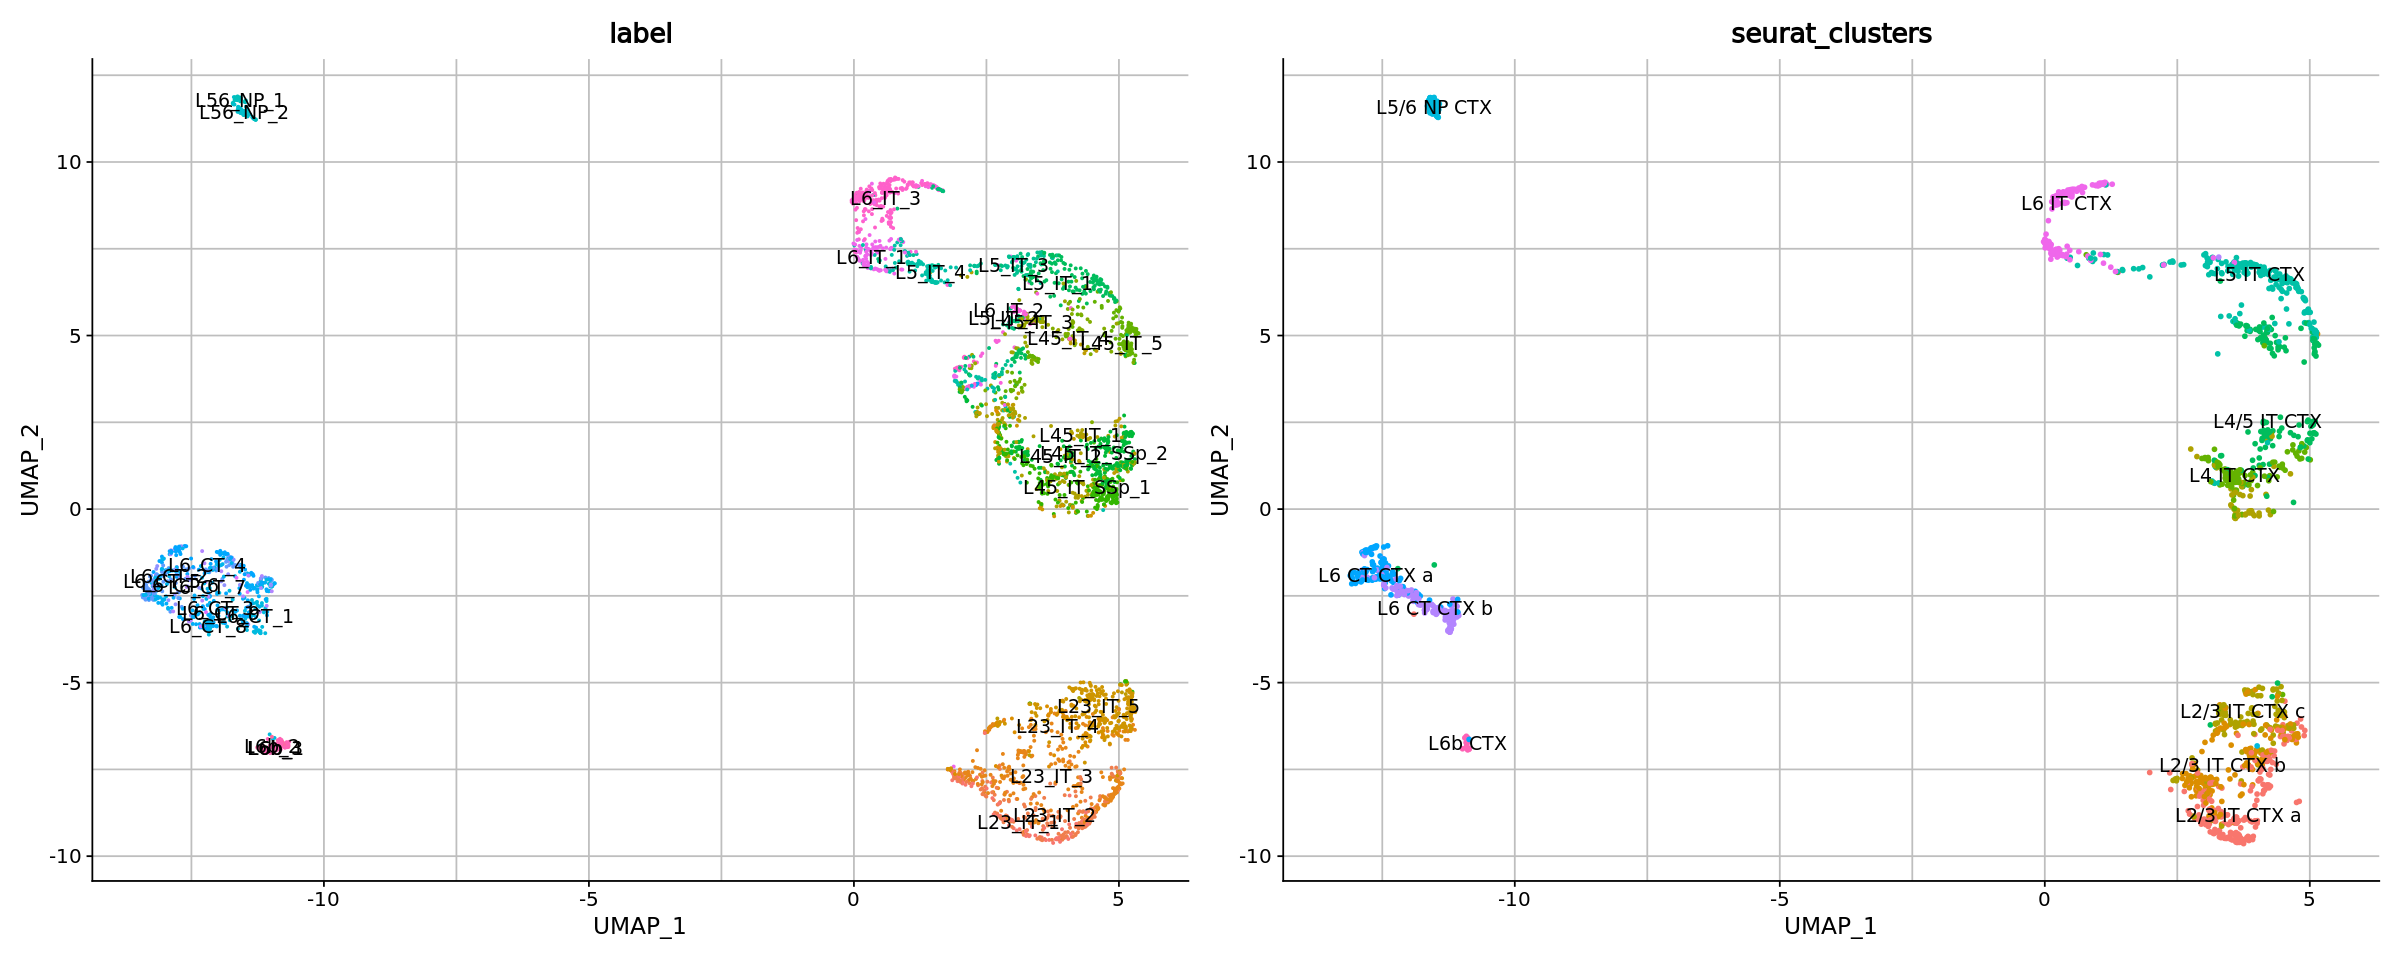

In [144]:
obj = obj.int.zhang2021
names = colnames(obj)[obj$dataset == 'CARE-seq']
obj$seurat_clusters[obj$dataset == 'CARE-seq'] = obj.care$seurat_clusters[names]

saved <- options(repr.plot.width=10, repr.plot.height=8)
DimPlot(obj, group.by="dataset")
options(saved)

saved <- options(repr.plot.width=20, repr.plot.height=8)
fn(DimPlot(subset(x=obj, subset=dataset == "Zhang2021"), group.by="slice_id", label=T, repel=F)+
   DimPlot(subset(x=obj, subset=dataset == "CARE-seq"), group.by='seurat_clusters', label=T, repel=F))
fn(DimPlot(subset(x=obj, subset=dataset == "Zhang2021"), group.by='class_label', label=T, repel=F)+
   DimPlot(subset(x=obj, subset=dataset == "CARE-seq"), group.by='seurat_clusters', label=T, repel=F))
fn(DimPlot(subset(x=obj, subset=dataset == "Zhang2021"), group.by='subclass', label=T, repel=F)+
   DimPlot(subset(x=obj, subset=dataset == "CARE-seq"), group.by='seurat_clusters', label=T, repel=F))
fn(DimPlot(subset(x=obj, subset=dataset == "Zhang2021"), group.by='label', label=T, repel=F)+
   DimPlot(subset(x=obj, subset=dataset == "CARE-seq"), group.by='seurat_clusters', label=T, repel=F))
options(saved)

In [141]:
f = function (subclass_list, seurat_clusters_list, slice_id_list, filename_suffix) {
#     message(Sys.time())
    obj.list <- list(
        subset(obj.zhang2021, subset=subclass%in%subclass_list & slice_id%in%slice_id_list),
        subset(obj.care, subset=seurat_clusters%in%seurat_clusters_list)
    )
    message(lapply(obj.list, dim))
#     message(Sys.time())
    features = intersect(rownames(obj.zhang2021), rownames(obj.care))
#     message(Sys.time())
    num_dims = 20
    anchors <- FindIntegrationAnchors(
        object.list = obj.list,
        anchor.features = features,
        dims = 1:num_dims,
        max.features = 1000,
        verbose=F)
#     message(Sys.time())
    obj <- IntegrateData(anchorset = anchors, verbose=F)
#     message(Sys.time())
    num_pcs = 30
    obj <- ScaleData(obj, verbose=F)
    obj <- RunPCA(obj, npcs = num_pcs, verbose=F)
    path2file = file.path(
        path2root, "results_mBC_integration_Zhang2021BICCN",
        paste0("PCA-Seurat-ndim", num_dims, "-", filename_suffix, '.csv'))
    message(path2file)
    write.csv(data.frame(obj[["pca"]]@cell.embeddings), path2file)
    obj
}

fn_err = function(error_message) {message('error!!!!!!!!!!!!!!!!!!!!!!'); return(NULL)}

subclass.exc = c("L2/3 IT", "L4/5 IT", "L5 IT", "L5/6 NP", "L6 CT", "L6 IT", "L6b")
subclass.inh = c("Lamp5", "Pvalb", "Sncg", "Sst", "Vip")
seurat_clusters.exc = c(
    "L2/3 IT CTX a", "L2/3 IT CTX b", "L2/3 IT CTX c", "L4 IT CTX", "L4/5 IT CTX",
    "L5 IT CTX", "L6 IT CTX", "L6 CT CTX a", "L6 CT CTX b", "L5/6 NP CTX", "L6b CTX")
seurat_clusters.inh = c("Pvalb a", "Pvalb b", "Sst a", "Sst b", "Vip", "Sncg", "Lamp5", "Meis2")

for (slice_id in sort(unique(obj.zhang2021$slice_id))) {
    message(paste(slice_id, Sys.time()))
    tryCatch(expr={f(subclass.inh, seurat_clusters.inh, c(slice_id), paste0('inh-', slice_id))}, error=fn_err)
    tryCatch(expr={f(subclass.exc, seurat_clusters.exc, c(slice_id), paste0('exc-', slice_id))}, error=fn_err)
}

mouse1_slice1 2023-03-15 23:20:46

c(254, 181)c(17019, 508)

Warning message in FilterAnchors(object = object.pair, assay = assay, slot = slot, :
“Number of anchor cells is less than k.filter. Retaining all anchors.”
/work/magroup/tianming/Researches/sc-hic/data2/final/results_mBC_integration_Zhang2021BICCN/PCA-Seurat-ndim20-inh-mouse1_slice1.csv

c(254, 1280)c(17019, 1665)

/work/magroup/tianming/Researches/sc-hic/data2/final/results_mBC_integration_Zhang2021BICCN/PCA-Seurat-ndim20-exc-mouse1_slice1.csv

mouse1_slice10 2023-03-15 23:21:17

c(254, 129)c(17019, 508)

Warning message in FilterAnchors(object = object.pair, assay = assay, slot = slot, :
“Number of anchor cells is less than k.filter. Retaining all anchors.”
/work/magroup/tianming/Researches/sc-hic/data2/final/results_mBC_integration_Zhang2021BICCN/PCA-Seurat-ndim20-inh-mouse1_slice10.csv

c(254, 1232)c(17019, 1665)

/work/magroup/tianming/Researches/sc-hic/data2/final/results_mBC_integration_Zhang2021BICCN/PCA-Seurat-ndim20

mouse1_slice283 2023-03-15 23:33:44

c(254, 263)c(17019, 508)

/work/magroup/tianming/Researches/sc-hic/data2/final/results_mBC_integration_Zhang2021BICCN/PCA-Seurat-ndim20-inh-mouse1_slice283.csv

c(254, 2408)c(17019, 1665)

/work/magroup/tianming/Researches/sc-hic/data2/final/results_mBC_integration_Zhang2021BICCN/PCA-Seurat-ndim20-exc-mouse1_slice283.csv

mouse1_slice291 2023-03-15 23:34:19

c(254, 232)c(17019, 508)

/work/magroup/tianming/Researches/sc-hic/data2/final/results_mBC_integration_Zhang2021BICCN/PCA-Seurat-ndim20-inh-mouse1_slice291.csv

c(254, 2392)c(17019, 1665)

/work/magroup/tianming/Researches/sc-hic/data2/final/results_mBC_integration_Zhang2021BICCN/PCA-Seurat-ndim20-exc-mouse1_slice291.csv

mouse1_slice301 2023-03-15 23:34:59

c(254, 235)c(17019, 508)

/work/magroup/tianming/Researches/sc-hic/data2/final/results_mBC_integration_Zhang2021BICCN/PCA-Seurat-ndim20-inh-mouse1_slice301.csv

c(254, 2438)c(17019, 1665)

/work/magroup/tianming/Researches/sc-hic/data2/final

mouse2_slice20 2023-03-15 23:46:27

c(254, 53)c(17019, 508)

Warning message in FilterAnchors(object = object.pair, assay = assay, slot = slot, :
“Number of anchor cells is less than k.filter. Retaining all anchors.”
error!!!!!!!!!!!!!!!!!!!!!!

c(254, 344)c(17019, 1665)

/work/magroup/tianming/Researches/sc-hic/data2/final/results_mBC_integration_Zhang2021BICCN/PCA-Seurat-ndim20-exc-mouse2_slice20.csv

mouse2_slice201 2023-03-15 23:46:48

c(254, 189)c(17019, 508)

Warning message in FilterAnchors(object = object.pair, assay = assay, slot = slot, :
“Number of anchor cells is less than k.filter. Retaining all anchors.”
/work/magroup/tianming/Researches/sc-hic/data2/final/results_mBC_integration_Zhang2021BICCN/PCA-Seurat-ndim20-inh-mouse2_slice201.csv

c(254, 1847)c(17019, 1665)

/work/magroup/tianming/Researches/sc-hic/data2/final/results_mBC_integration_Zhang2021BICCN/PCA-Seurat-ndim20-exc-mouse2_slice201.csv

mouse2_slice209 2023-03-15 23:47:17

c(254, 256)c(17019, 508)

/work/magroup